# <font style="color:blue">Check Training Pipeline</font>


In one of our videos under `Training Deep Networks`, we have discussed some points regarding the Training Pipeline.   
Following are the points written in code. 

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

### <font style="color:blue">1. Fix random seed</font>

We deal with only one numeric computational library i.e Pytorch. So we'll set its random seed.
Following is the code to do so.

In [2]:
torch.manual_seed(0)

### <font style="color:blue">2. Use a simple baseline model</font>


Throughout this notebook we will discuss the 10-points by using a simple dataset. This dataset is a small subset from the Caltech-101 data which can be downloaded from here.
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

This subset data spans across 4 classes i.e [chandelier, watch, laptop, motorbike] with roughly 400 images in total.

We will use a simple Image Classification network which consists of a few Convolutional and Linear layers. The input size will be (3, 160, 160) and the output nodes will be 4.

Let's define a simple model in the following block.

In [11]:
class Net(nn.Module):
    def __init__(self,n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1)
        self.fc1 = nn.Linear(10368, 2048)
        self.fc2 = nn.Linear(2048,128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### <font style="color:blue">3. Turn-off  data augmentation</font>

Sometimes, we use augmentation techniques such as random-rotation, adding small noise, translating the image etc.
When we are ensuring reproducibility, we do not need such techniques. We shall only use Resizing, Cropping and Normalization since they are non-deterministic.

The images in the data span various sizes, therefore we need to fix the size to `(160,160)` since this is the size our model expects as input.

We will also need a generator which will give us the required batch of images as we train. Pytorch provides a good handle for this as well.
Don't worry if you don't understand the below code. It will be taught in the upcoming lectures.
As of now, you just need to know that the following code does the preprocessing step (without any augmentation) and gives us the data-generator for feeding to the neural-network.

Following is the code.

In [5]:
from torchvision import datasets, transforms

preprocess = transforms.Compose([transforms.Resize((196,196)),transforms.CenterCrop((160,160)),
                                 transforms.ToTensor()])

data_root = "./resource"
    
train_data_path = os.path.join(data_root, 'train')
test_data_path = os.path.join(data_root, 'test')


train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root=train_data_path, transform=preprocess),
    batch_size=16,
    shuffle=True,
    num_workers=2)



test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root=test_data_path, transform=preprocess),
    batch_size=16,
    shuffle=False,
    num_workers=2
)

### <font style="color:blue">4. Visualize input data before it goes inside the network</font>

This step ensures that the input goes inside the network as expected. It's just a sanity-check.
We can use image-visualizing libraries such as `PIL`, `OpenCV` or `Matplotlib` to achieve this process.
We will use the `train_loader` to give us the batch of images and pick some samples and plot them.
Please consider omitting the `transforms.Normalize()` if you are using it during the pre-processing step. Because, if normalization is present then the pixel values would not be in the range of `[0-255]`.

Following is the code to visualize some of the images.

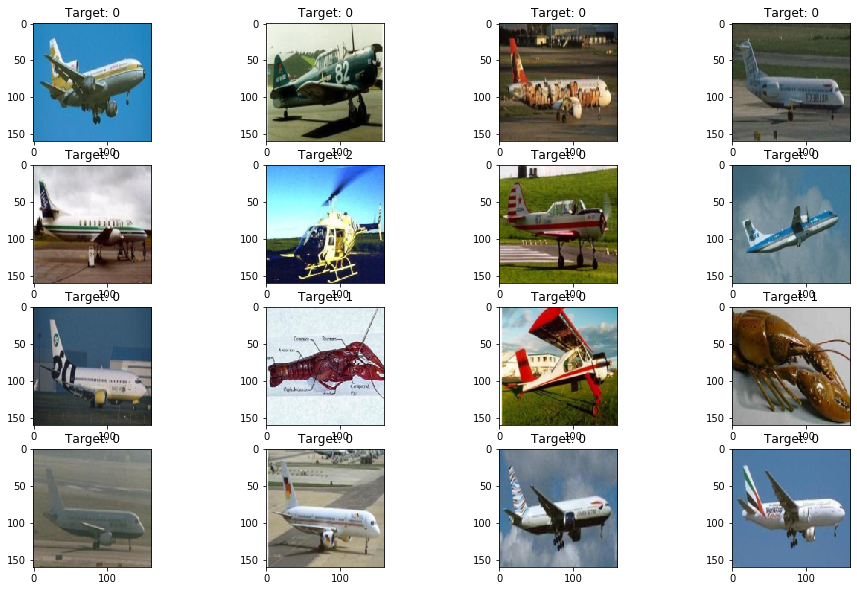

In [8]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 10)
plt.figure
for images, labels in train_loader:
    for i in range(len(labels)):
        plt.subplot(4, 4, i+1)
        img = transforms.functional.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

### <font style="color:blue">5. Check initial loss and accuracy.</font>

We will verify if a model is initialized randomly, then the initial loss must be around `log(num_classes)` and the initial accuracy must be around `1/num_classes` 


We shall create a class `CheckInitLossAndAccuracy` for verifying the 5th point by calculating the loss and accuracy.
We will need the following arguments:-
1. A randomly initialized model.
2. A batch of input.
3. A batch of  target classes.
4. Number of classes.


The class has two methods called `verify_init_loss` which verifies if the intial loss is around `log(num_classes)` and `verify_init_accuracy` which verifes if the initial accuracy is around `1/num_classes`.

In [15]:
class CheckInitLossAndAccuracy():
    def __init__(self, net, x, num_classes, target = None):
        self.net = net
        self.x = x
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = self.x.size()[0]
        if target is None:
            self.target = torch.randint(0, self.num_classes, size=(self.batch_size,))
        else:
            self.target = target
        self.logits = self.net(self.x)

    def verify_init_loss(self):
        loss = self.criterion(self.logits, self.target)
        print("Expected loss is ", np.log(self.num_classes))
        print("Inferred loss is ", loss.item())
        return None

    def verify_init_accuracy(self):
        predictions = torch.argmax(F.softmax(self.logits, dim=1), axis=1)
        accuracy = accuracy_score(self.target, predictions.detach())
        print("Expected accuracy is ", 1 / self.num_classes)
        print("Inferred accuracy is ", accuracy)
        return None


In [17]:
from sklearn.metrics import accuracy_score

n = 4
x, target = next(iter(train_loader))

print("num classes are ", n)
model = Net(n)
check = CheckInitLossAndAccuracy(model, x, n, target)
check.verify_init_loss()
check.verify_init_accuracy()

num classes are  4
Expected loss is  1.3862943611198906
Inferred loss is  1.4461774826049805
Expected accuracy is  0.25
Inferred accuracy is  0.0625


 Looking at the numbers, they are approximately equal!

### <font style="color:blue">6. Check if loss goes down every epoch.</font>

In-order to check if the loss goes down every epoch, we need to set-up the typical training procedure for a Neural Network. We also need to store the loss values in a list or an array, so that it can be vizualized later after training gets over.

Following is the code to do so.

In [18]:
import torch.optim as optim

num_classes = 4
x, target = next(iter(train_loader))

model1 = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum = 0.9)


loss_list = []
num_epochs = 10
for epoch in range(num_epochs): 
    per_epoch_loss= 0
    for i, data in enumerate(train_loader): 
        optimizer.zero_grad()
        logits = model1(x)
        loss = criterion(logits, target)
        temp_loss = loss.item()
        per_epoch_loss+=temp_loss
        loss.backward()
        optimizer.step()
        
    per_epoch_avg_loss = per_epoch_loss/(i+1)
    loss_list.append(per_epoch_avg_loss)
    print("Loss at epoch {0} = {1}".format(epoch+1, per_epoch_avg_loss ))

Loss at epoch 1 = 1.1757378032651997
Loss at epoch 2 = 0.3588639346219726
Loss at epoch 3 = 0.2622299638845153
Loss at epoch 4 = 0.23259750463194767
Loss at epoch 5 = 0.1435141934681747
Loss at epoch 6 = 0.021937908202220323
Loss at epoch 7 = 0.0037859040983336963
Loss at epoch 8 = 0.0017639042600452648
Loss at epoch 9 = 0.0010994598950196247
Loss at epoch 10 = 0.0007770028600658654


We have kept track of the `loss` at every epoch in the `loss_list`, let's use them to plot the loss-curve.

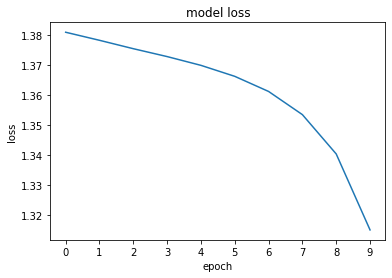

In [9]:
plt.figure(figsize = (6,4))
plt.plot(loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,10))
plt.show()

We see from the loss-curve that the loss is indeed dropping down.

### <font style="color:blue">7. Forward the same batch for multiple interations and check if loss drops down to 0 </font>

We will use the same code mentioned above, except that we will not iterate over the batch, but forward the same batch and monitor the loss. Note that we shall use the `Adam` optimizer rather than the `SGD` due to the fact that `SGD`  updates the parameters very slowly and skips the minima easily. 
Since we want to verify that the loss approaches zero and does not skip it, we want a suitable optimizer, and one such is `Adam` .

Following is the code.

In [10]:
import torch.optim as optim

num_classes = 4
model2 = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

x, target = next(iter(train_loader))


loss_list = []
num_iters = 25
for i in range(num_iters): 
    optimizer.zero_grad()
    logits = model2(x)
    loss = criterion(logits, target)
    temp_loss = loss.item()
    loss.backward()
    optimizer.step()
    loss_list.append(temp_loss)
    print("Loss at iteration-{} is {}".format(i+1,temp_loss))

Loss at iteration-1 is 1.3900073766708374
Loss at iteration-2 is 1.3495010137557983
Loss at iteration-3 is 1.3070727586746216
Loss at iteration-4 is 1.2745351791381836
Loss at iteration-5 is 1.245995044708252
Loss at iteration-6 is 1.1873728036880493
Loss at iteration-7 is 1.0866321325302124
Loss at iteration-8 is 0.9779016971588135
Loss at iteration-9 is 0.844036340713501
Loss at iteration-10 is 0.7530232071876526
Loss at iteration-11 is 0.5914379358291626
Loss at iteration-12 is 0.3918510377407074
Loss at iteration-13 is 0.22971172630786896
Loss at iteration-14 is 0.15298046171665192
Loss at iteration-15 is 0.08443832397460938
Loss at iteration-16 is 0.04787296801805496
Loss at iteration-17 is 0.01700103096663952
Loss at iteration-18 is 0.012461632490158081
Loss at iteration-19 is 0.0019266910385340452
Loss at iteration-20 is 0.0035095831844955683
Loss at iteration-21 is 0.0007415897562168539
Loss at iteration-22 is 0.000377367134205997
Loss at iteration-23 is 0.000537537969648838
Lo

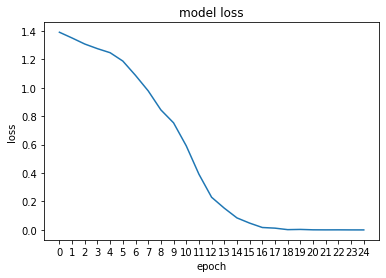

In [11]:
# Let's plot the loss curve.

plt.figure(figsize = (6,4))
plt.plot(loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,i+1))
plt.show()

### <font style="color:blue">8. Forward-pass a zero input and check if loss is high</font>

For this, we will use a model trained in 6th point i.e `model1` and look at the loss.
The `input` or `x` to this model will be Tensors of zeros and the `target` will be a set of random numbers between `0` and `3`.    
We got a final loss of `1.314` in the 10th epoch, so we expect that the randomized input shall produce a much higher loss than this.

In [12]:
criterion = nn.CrossEntropyLoss()

x = torch.zeros(size = (16,3,160,160))
target = torch.randint(0,4,size = (16,))
logits = model1(x)

loss = criterion(logits,target)
print("Loss with zero-valued input is ", loss.item())

Loss with zero-valued input is  1.37798273563385


### <font style="color:blue">9. Calculate the loss on entire test-set </font>

For this, we already have a generator called the `test_loader`. Everytime we want to test our model's performance, we will use this generator.
The following code will calculate the test-loss on entire test-set every 2 epochs. 
Note that we can calculate the test-loss at every epoch as well, it really depends on the user as to how frequently the loss needs to be logged.

We will use the same code mentioned in 6th point but with a few extra lines of code for calculating the test-loss.
Following is the code.

In [13]:
import torch.optim as optim

num_classes = 4
model3 = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)


loss_list = []
num_epochs = 10
for epoch in range(num_epochs): 
    per_epoch_loss= 0
    for i, data in enumerate(train_loader): 
        optimizer.zero_grad()
        logits = model3(x)
        loss = criterion(logits, target)
        temp_loss = loss.item()
        per_epoch_loss+=temp_loss
        loss.backward()
        optimizer.step()
    per_epoch_avg_loss = per_epoch_loss/(i+1)
    loss_list.append(per_epoch_avg_loss)
    print("Traning loss at epoch {} = {}".format(epoch+1, per_epoch_avg_loss ))
    
    if(epoch+1)%2==0:
        total_test_loss = 0
        with torch.no_grad():
            model3.eval()
            for j, test_data in enumerate(test_loader):
                test_x, test_target = test_data
                test_logits = model3(test_x)
                test_loss = criterion(test_logits, test_target)
                total_test_loss+= test_loss.item()
            print("Test loss at epoch {} = {}".format(epoch+1, total_test_loss/(j+1)))
            

Traning loss at epoch 1 = 1.391470159093539
Traning loss at epoch 2 = 1.3862233012914658
Test loss at epoch 2 = 1.3898473680019379
Traning loss at epoch 3 = 1.3813048700491588
Traning loss at epoch 4 = 1.377105176448822
Test loss at epoch 4 = 1.4032139778137207
Traning loss at epoch 5 = 1.3735911399126053
Traning loss at epoch 6 = 1.3706754098335903
Test loss at epoch 6 = 1.4155327081680298
Traning loss at epoch 7 = 1.3681743840376537
Traning loss at epoch 8 = 1.3660114804903667
Test loss at epoch 8 = 1.4272787272930145
Traning loss at epoch 9 = 1.3641531219085057
Traning loss at epoch 10 = 1.3625633517901103
Test loss at epoch 10 = 1.4383728206157684


### <font style="color:blue">10. Check dimensions using Backprop</font>

Let's break-down the points discussed in the video with a concrete example.

1. Consider a simple network with just a few Convolutional and Linear layers whose input is (1,28,28) and output is 10 nodes.

2. We will consider the batch-size to be 25. Therefore, input size will be (25,1,28,28) and the output size will be (25,10).

3. Once we get the output, we plug this output inside the Loss function to get a loss. Typically, this loss is just one element (a scalar), which is either summed or averaged over the 25 loss-values. However, we can get the un-summed and un-averaged loss-values by passing `reduction='none'` when instantiating `nn.CrossEntropyLoss()`. 
Now, if we evaluate the loss, it would not be a scalar, but a vector of 25 entries where each entry corresponds to the loss for each image in the batch.

4. As discussed in the video, we need to keep only one entry ( eg. 11th entry ) in this 25-d loss-vector intact, and set all the rest 24 entries to zero. And then calculate the gradients via backpropogation from this modified loss.

5. Now that we have backpropogated, its gradients can be accessed. At this point, note that the gradients should be of size (25, 784, 10), where each entry in the first dimension corresponds to the gradients for each image.

According to our claim, if the dimensions are right, then the gradients in the 11th entry will be non-zero, and the gradients in the rest will be zero.
However, instead of checking if the entries are zero, we could just sum up the gradients along the batch (first) dimension and look at the resulting 25 numbers. We will notice that the index with the highest number will be 11 indicating that the gradients at the 11th entry are non-zero.

If the dimensions are not right, then the index will not be 11.



NOTE:

In order to verify this claim using code, there is a small bottleneck.   
Pytorch expects `loss` to be scalar, it will throw an error if a Tensor ( in our case, if a 25-d vector ) is passed.  
And due to this, the gradients which we can access after `loss.backward()` will be of size `(784,10)` and not `(25,784,10)`, i.e the gradients will be summed-out or averaged-out over the 25 entries.     
But, no worries, we will show you a work-around for this.

   
This work-around is carried out in two steps

STEP-1 `get_batched_gradients_metric`

1. Follow the same steps upto the 4th point, i.e keeping only the 11th entry intact, and set the rest entries to 0, and    SUM-THEM-UP. Now that we have a Scalar, and we can easily backprop this. 
2. After backprop, the gradients are expected to be of size `(784,10)`. However, we are not sure if these gradients really belonged to the 11th image or not. So, we need to perform one more step to verify if these gradients did really belong to the 11th image or not.

3. As a side note, let's not look at the whole set of gradients, instead, we'll look at its absolute-sum, it will be much easier to compare. 


STEP-2 (as a verification method for step-1 ) `get_individual_gradients_metric`

1. Follow the same steps upto the 4th point, i.e keeping only the 11th entry intact, and set the rest entries to 0.
Instead of summing the Loss-vector and bringing it to a Scalar, we will do it in an iterative way over the whole batch.
2. For each image in the batch, we backprop with its corresponding loss. This essentially means that, only the 11th image will have a non-zero loss, because the rest loss entries will be zero.   We will also keep track of the absolute sum of gradients for each image.
4. Once the iteration on the batch is over, we will have 25 such gradient-sums. 


In step-2, we should notice that only the gradient-sum at the 11th entry will be non-zero, rest will be zero.
Also, this non-zero value must be exactly equal to the number we get in step-1.
Thus indicating that only the 11th entry over the batch has gradients, in turn indicating that the dimensions are correct.



We will use the class `Check_dims_via_backprop` for verifying the 10th point. The class expects the following parameters:-
1. Input batch
2. The Network-class
3. Target batch
4. A random number indication which image in the batch we want to experiment with

As mentioned above, we have to execute two steps to claim the statement mentioned above.
The method `get_batched_gradients_metric()` will give us the gradient-sum as mentioned in STEP-1.
The method `get_individual_gradients_metric()` will give us the gradient-sum for each image as mentioned in STEP-2.

In [14]:
class CheckDimsViaBackprop():
    def __init__(self, net_class, x, num_classes, target=None, which_sample=11):
        self.first_model = None
        self.net_class = net_class
        self.x = x
        self.num_classes = num_classes
        self.batch_size = self.x.size()[0]
        self.which_sample = which_sample
        if target is None:
            self.target = torch.randint(0, self.num_classes, size=(self.batch_size,))
        else:
            self.target = target

    def get_batched_gradients_metric(self):
        first_model = self.net_class(self.num_classes)
        self.first_model = first_model
        criterion = nn.CrossEntropyLoss(reduction='none')

        logits = first_model(self.x)
        loss = criterion(logits, self.target)

        mask = torch.zeros_like(loss)
        mask[self.which_sample] = 1
        loss *= mask
        loss = loss.sum()
        loss.backward()
        grad_metric = abs(sum([p.grad.numpy().sum() for p in list(first_model.parameters())]))
        print("Batched Gradient metric =  ", grad_metric)
        return None

    def get_individual_gradients_metric(self):
        second_model = self.net_class(self.num_classes)
        second_model.load_state_dict(self.first_model.state_dict())

        criterion = nn.CrossEntropyLoss(reduction='none')
        logits = second_model(self.x)
        loss = criterion(logits, self.target)

        mask = torch.zeros_like(loss)
        mask[self.which_sample] = 1
        loss *= mask
        temp_loss = loss.clone()

        for i in range(len(temp_loss)):
            second_model.zero_grad()
            temp_img = self.x[i, ...]
            op = second_model(torch.unsqueeze(temp_img, 0))
            temp_target = torch.Tensor([self.target[i]]).long()
            loss = criterion(op, temp_target)
            loss = temp_loss[i]
            loss.backward(retain_graph=True)
            grads = [p.grad.numpy().sum() for p in list(second_model.parameters())]
            grad_metric = abs(sum(grads))
            if grad_metric > 0:
                print("Gradient metric at sample {} =  ".format(i), grad_metric)
        return None


Following is an example of using the above class.
As usual, we will grab a batch from the `train_loader`, and we shall experiment with the image at the 11th entry, just to remain consistent with the explanation.

In [15]:
num_classes  = 4

x, target = next(iter(train_loader))


which_one = 11
check2 = CheckDimsViaBackprop(Net, x, num_classes, target, which_one)# NOTE - this will expect the nn.Module class, not the nn.Module object!
assert which_one < x.size()[0]

check2.get_batched_gradients_metric()
check2.get_individual_gradients_metric()

Batched Gradient metric =   14.70959197729826
Gradient metric at sample 11 =   14.70959197729826


The gradient-sum we got from STEP-1 is present at the 11th index, clearly indicating that the dimensions are right!

References
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html